In [1]:
import pandas as pd
import numpy as np
from numpy import percentile

import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from pyod.models.hbos import HBOS

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Загрузка данных 

In [2]:
df = pd.read_csv('../data/task_data_middle.csv', low_memory=False, parse_dates=["date"])
df

,id,date,inetnum
0,0,2021-11-21 11:01:16,83.220.236.0-83.220.239.255
1,1,2021-11-21 11:01:21,81.9.0.0-81.9.127.255
2,2,2021-11-21 11:01:31,83.169.216.0-83.169.216.255
3,3,2021-11-21 11:01:33,178.204.0.0-178.205.255.255
4,4,2021-11-21 11:01:42,176.215.0.0-176.215.7.255
...,...,...,...
727043,727043,2022-02-21 10:02:41,128.75.0.0-128.75.127.255
727044,727044,2022-02-21 10:02:48,195.58.56.0-195.58.63.255
727045,727045,2022-02-21 10:03:13,80.83.236.0-80.83.239.255
727046,727046,2022-02-21 10:03:24,109.184.128.0-109.184.255.255


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727048 entries, 0 to 727047
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   id       727048 non-null  int64         
 1   date     727048 non-null  datetime64[ns]
 2   inetnum  727048 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 16.6+ MB


### Анализ данных

In [4]:
print('Количество уникальных источников обращений', len(df['inetnum'].unique()))

Количество уникальных источников обращений 14868


In [5]:
print('Явных дубликатов в таблице *df*:', df.duplicated().sum())

Явных дубликатов в таблице *df*: 0


In [6]:
# Добавим колонку CNT с 1 - для дальнейшего подсчета по каждому IP
df['cnt'] = 1

In [7]:
df.drop('id', axis=1, inplace=True)

In [8]:
print('Начальная дата: ', df['date'].min(), 'последняя дата: ', df['date'].max())
print('Период временного ряда равен: ', df['date'].max() - df['date'].min())

Начальная дата:  2021-11-21 11:01:16 последняя дата:  2022-02-21 10:03:27
Период временного ряда равен:  91 days 23:02:11


In [9]:
df1 = pd.DataFrame(df.groupby([df["date"], "inetnum"])["cnt"].sum())

In [10]:
df1 = df1.reset_index('inetnum')

In [11]:
df1

,inetnum,cnt
date,,
2021-11-21 11:01:16,83.220.236.0-83.220.239.255,1
2021-11-21 11:01:21,81.9.0.0-81.9.127.255,1
2021-11-21 11:01:31,83.169.216.0-83.169.216.255,1
2021-11-21 11:01:33,178.204.0.0-178.205.255.255,1
2021-11-21 11:01:42,176.215.0.0-176.215.7.255,1
...,...,...
2022-02-21 10:02:41,128.75.0.0-128.75.127.255,1
2022-02-21 10:02:48,195.58.56.0-195.58.63.255,1
2022-02-21 10:03:13,80.83.236.0-80.83.239.255,1


In [12]:
print(df.index.is_monotonic_increasing)

True


Индексы даты упорядочены, таблица представляет собой временной ряд с которым можно работать дальше.
Необходимо создать таблицу отражающую число обращений из каждой сети в каждый час за всю историю наблюдений.
Полагаю, в дальнейшем, это позволит легко находить нужную сеть по ее уникальному диапазону IP адресов и строить временной ряд для нее (или нескольких сетей)

Формулировка в ТЗ "в разрезе дня" мною понята, как "выявить аномалии по часам в течении дня", таким образом ресемпилируем по 1 часу. 

In [13]:
grouper = df1.groupby([pd.Grouper(freq='1H'), 'inetnum'])

In [14]:
df_pv = grouper['cnt'].count().unstack('inetnum').fillna(0)

In [15]:
df_pv

inetnum,0.0.0.0-1.178.111.255,0.0.0.0-255.255.255.255,1.179.128.0-1.255.255.255,101.56.0.0-101.63.255.255,101.64.0.0-103.7.203.255,103.212.83.0-103.214.43.255,103.216.64.0-103.219.19.255,103.219.24.0-103.225.127.255,103.24.240.0-103.26.123.255,103.248.188.0-103.251.163.255,...,95.86.192.0-95.86.199.255,95.86.200.0-95.86.207.255,95.86.209.0-95.86.209.255,95.86.212.0-95.86.215.255,95.86.216.0-95.86.219.255,95.86.220.0-95.86.223.255,95.86.224.0-95.86.255.255,95.90.0.0-95.91.255.255,96.125.160.0-98.96.159.255,98.158.239.0-101.55.255.255
date,,,,,,,,,,,,,,,,,,,,,
2021-11-21 11:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-21 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-21 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-21 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-21 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-21 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-21 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-21 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Мы получили сводную таблицу, в которой учтены все запросы (colls) за все периоды наблюдения, отсемплированые до 1 часа.

Но сетей очень много (14868), и в большинстве из них - единичные обращения за весь период наблюдений. Т.е по таким сетям временной ряд малоинформативен для оценки аномалий. 
Полагаю, надо избавиться от сетей, где суммарное число обращений меньше, чем число наблюдений * 2 как минимум  (2206 * 2 = **4414**)

Рассчитаем суммарное число обращений по каждой сети и выведем в top выведем значения, которые не меньше 4414

In [16]:
values = df_pv.sum(axis=0)

In [17]:
top = values[values >= 4414]
print('Число сетей с максимальной частотой обращений:', len(top))

Число сетей с максимальной частотой обращений: 25


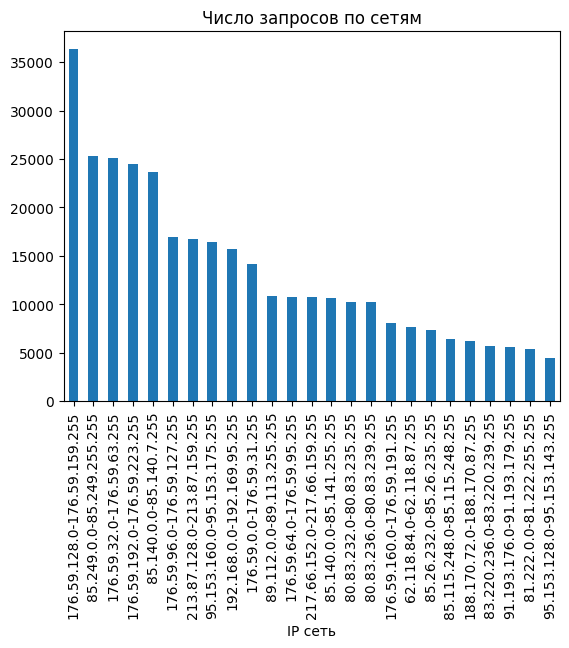

In [18]:
top.sort_values(ascending=False).plot.bar(stacked=True, title='Число запросов по сетям', xlabel='IP сеть');

Для удобства выделим первые 5 сетей, вносящих основной вклад обращений.

In [19]:
top_5 = df_pv.loc[:, df_pv.sum(axis=0) > 20000].copy()
top_5 = top_5.resample('1H').sum()

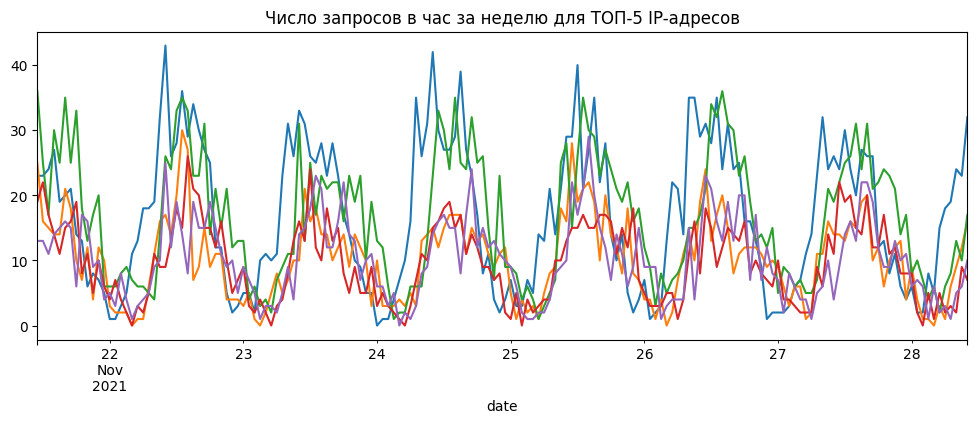

In [20]:
def ts_plot(table, title, size, legend=True):
    plt.figure(figsize=size)
    plt.title(title)
    if not legend:
        table.plot(ax=plt.gca(), legend=None)
    else:
        table.plot(ax=plt.gca())

ts_plot(top_5[:168], "Число запросов в час за неделю для ТОП-5 IP-адресов", (12,4), legend=None)

In [21]:
top_5['avg_top5'] = top_5.mean(axis=1)
top_5['avg_all'] = df_pv.mean(axis=1)

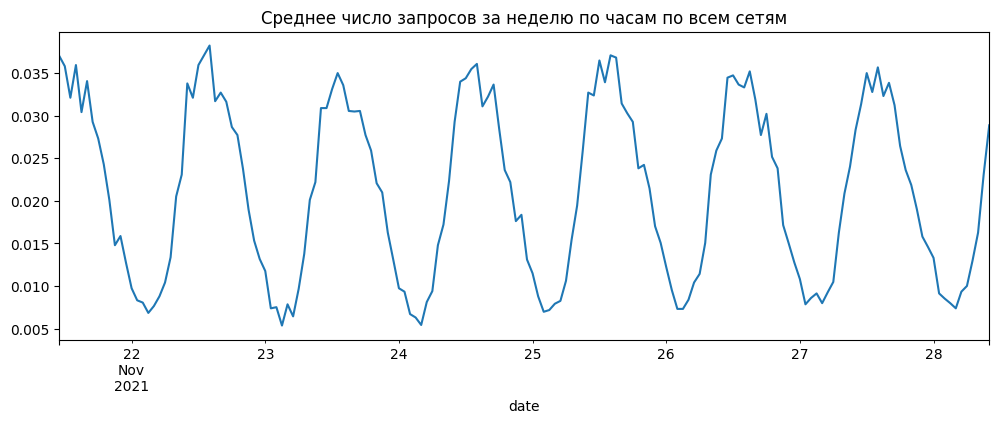

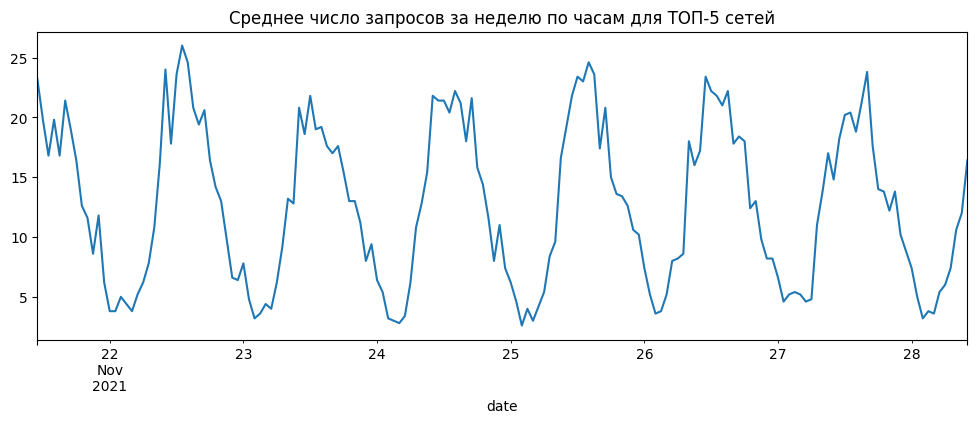

In [22]:
ts_plot(top_5['avg_all'][:168], "Среднее число запросов за неделю по часам по всем сетям", (12,4))
ts_plot(top_5['avg_top5'][:168], "Среднее число запросов за неделю по часам для ТОП-5 сетей", (12,4))

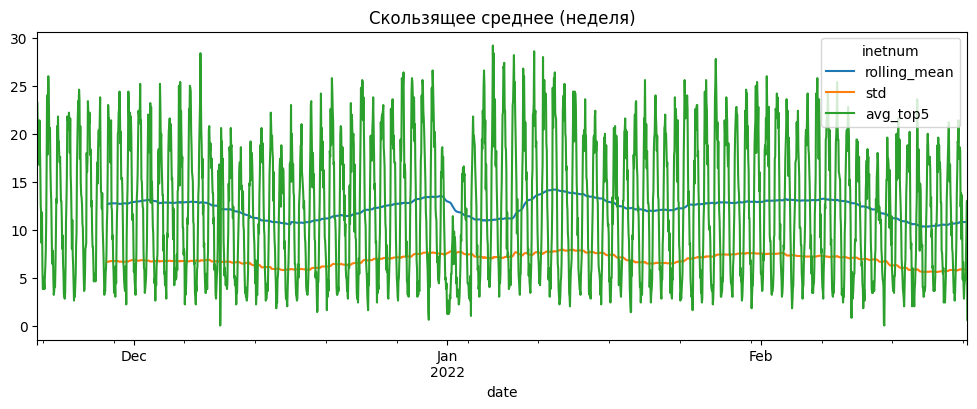

In [23]:
data = top_5.copy()
data['rolling_mean'] = data['avg_top5'].rolling(24*7).mean()
data['std'] = data['avg_top5'].rolling(24*7).std()
ts_plot(data[['rolling_mean', 'std', 'avg_top5']], "Скользящее среднее (неделя)", (12,4))

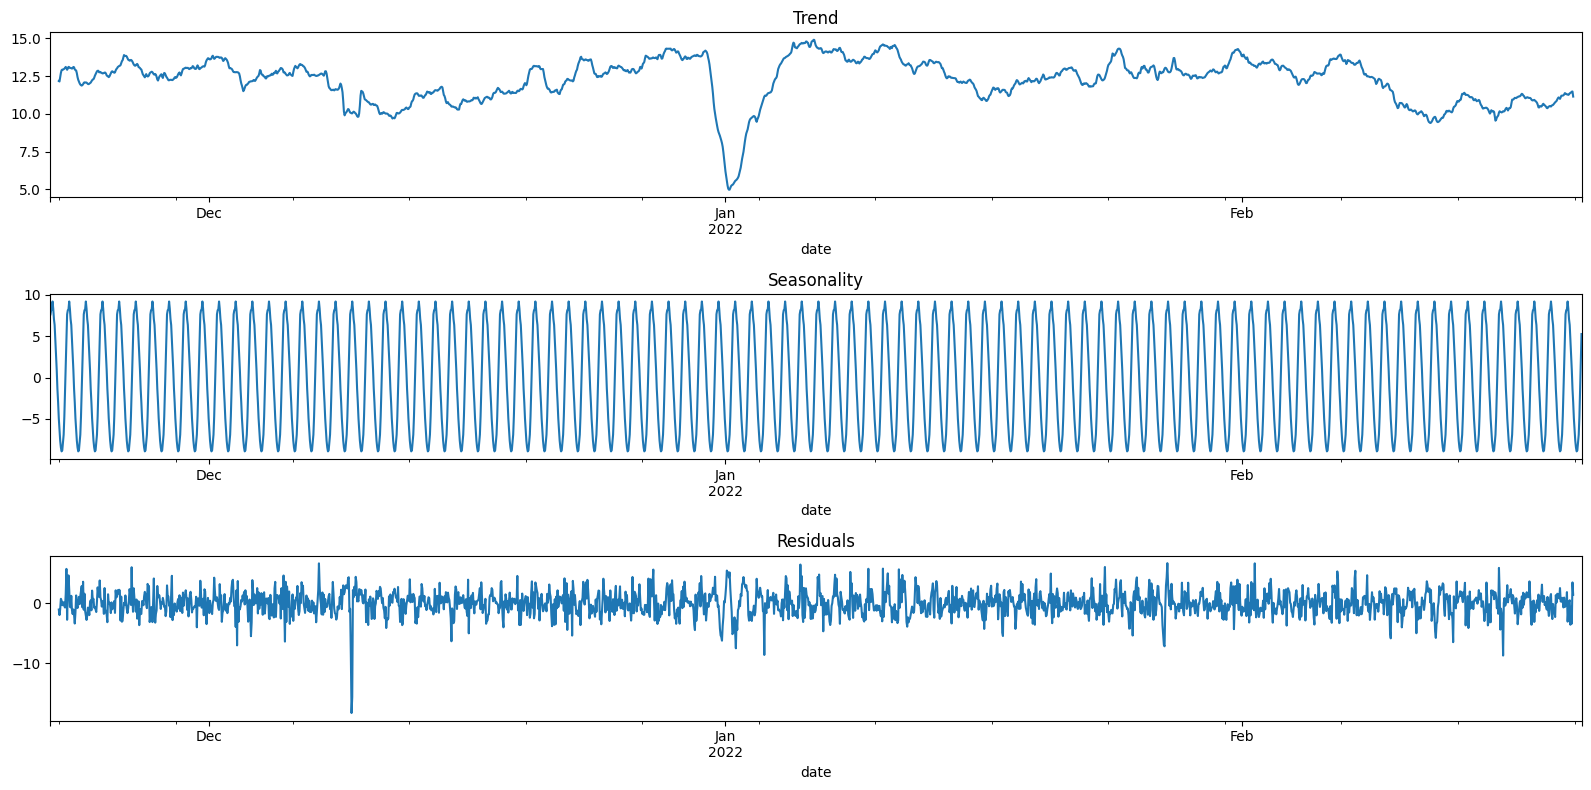

In [24]:
decomposed = seasonal_decompose(top_5['avg_top5'])

plt.figure(figsize=(16, 8))
plt.subplot(311)

ax=plt.gca()
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

[]

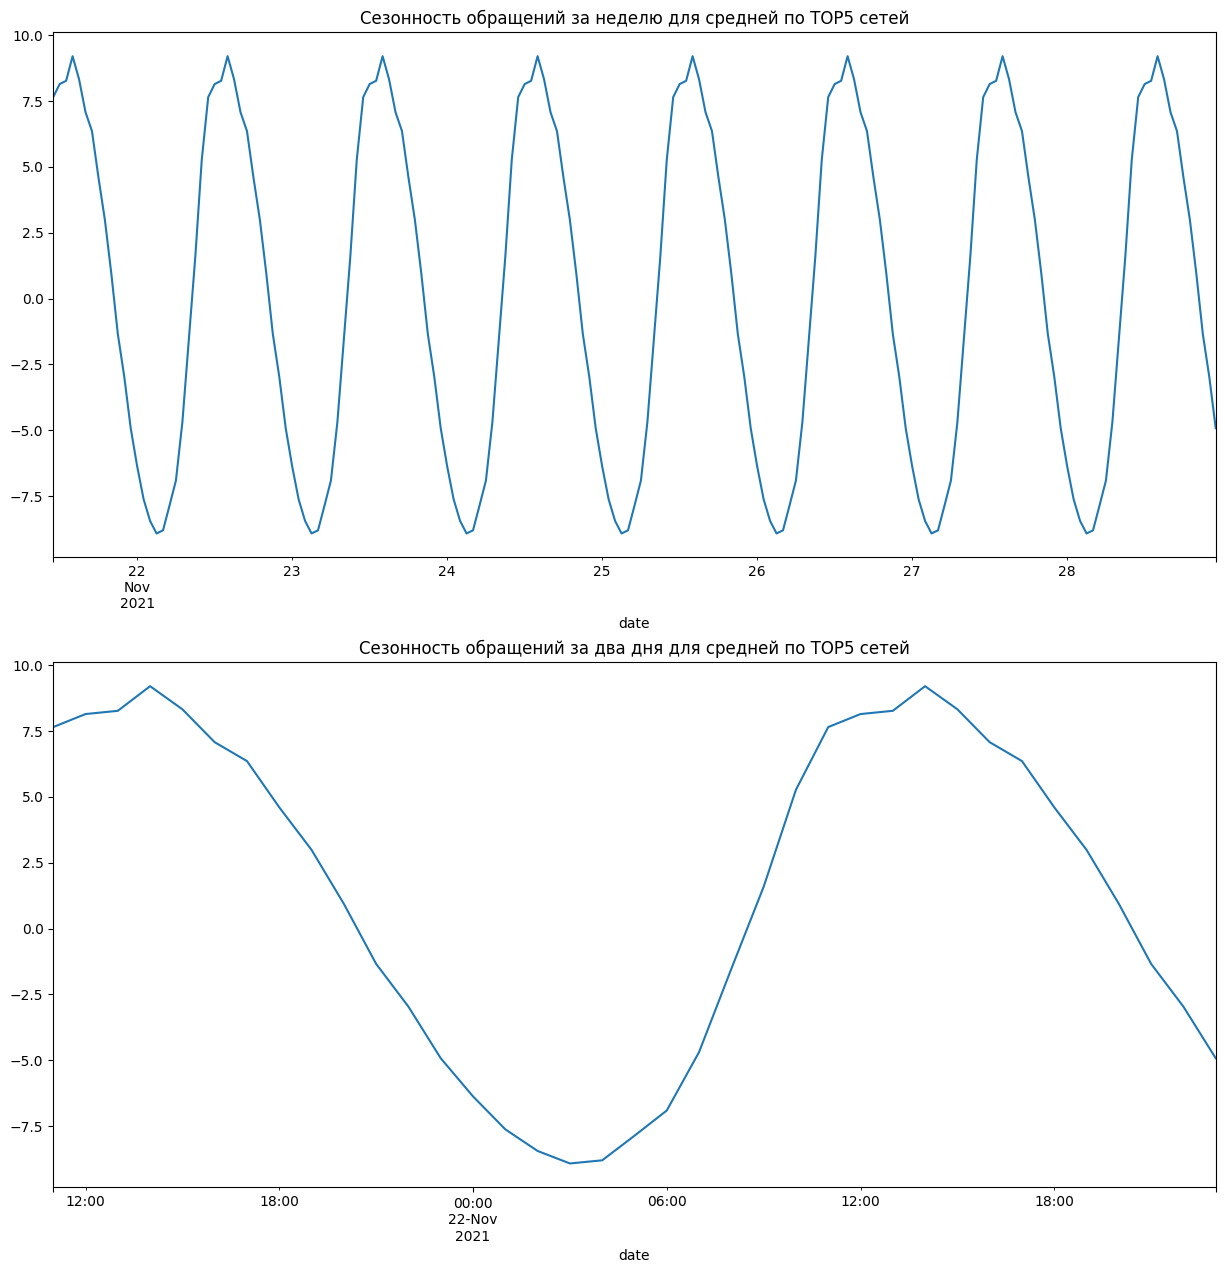

In [25]:
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.title("Сезонность обращений за неделю для средней по TOP5 сетей")
decomposed.seasonal['2021-11-21':'2021-11-28'].plot(ax=plt.gca())
plt.subplot(212)
decomposed.seasonal['2021-11-21':'2021-11-22'].plot(ax=plt.gca()) 
plt.title('Сезонность обращений за два дня для средней по TOP5 сетей')
plt.plot()

### Первичные выводы

- Наблюдается характерные колебания числа обращений внутри дня
- Временной ряд можно считать стационарным: Среднее и стандартное отклонение не имеют тенденции к росту или падению
- На графике отчетливо видна "Аномалия новогодних праздников"

### Построение моделей для поиска аномалий


#### Модель IsolationForest

In [26]:
def scale_ip_data(data: pd.Series) -> pd.DataFrame:
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(data.values.reshape(-1,1))
    return pd.DataFrame(np_scaled)


In [27]:
def isolation_forest(data: pd.DataFrame, coll: str, cont: float = 0.05) -> np.array:
    data = scale_ip_data(data[coll])
    model = IsolationForest(contamination=cont, random_state=RANDOM_STATE)
    model.fit(data)
    return model.predict(data)

In [28]:
def show_anomaly_chart(data: pd.DataFrame, coll: str, marker_digit: int = -1):
    fig, ax = plt.subplots(figsize=(16, 9))
    if marker_digit == -1:
        a = data.loc[data.anomaly == -1, [coll]]
    else:
        a = data.loc[data.anomaly == 1, [coll]]

    ax.plot(data.index, data[coll])
    ax.scatter(a.index, a[coll], color='red')
    plt.show()

In [29]:
def create_iso_forest_chart(data: pd.DataFrame, coll: str, cont_factor: float = 0.05):
    result = isolation_forest(data=data, coll=coll, cont=cont_factor)
    data['anomaly'] = result
    show_anomaly_chart(data, coll)

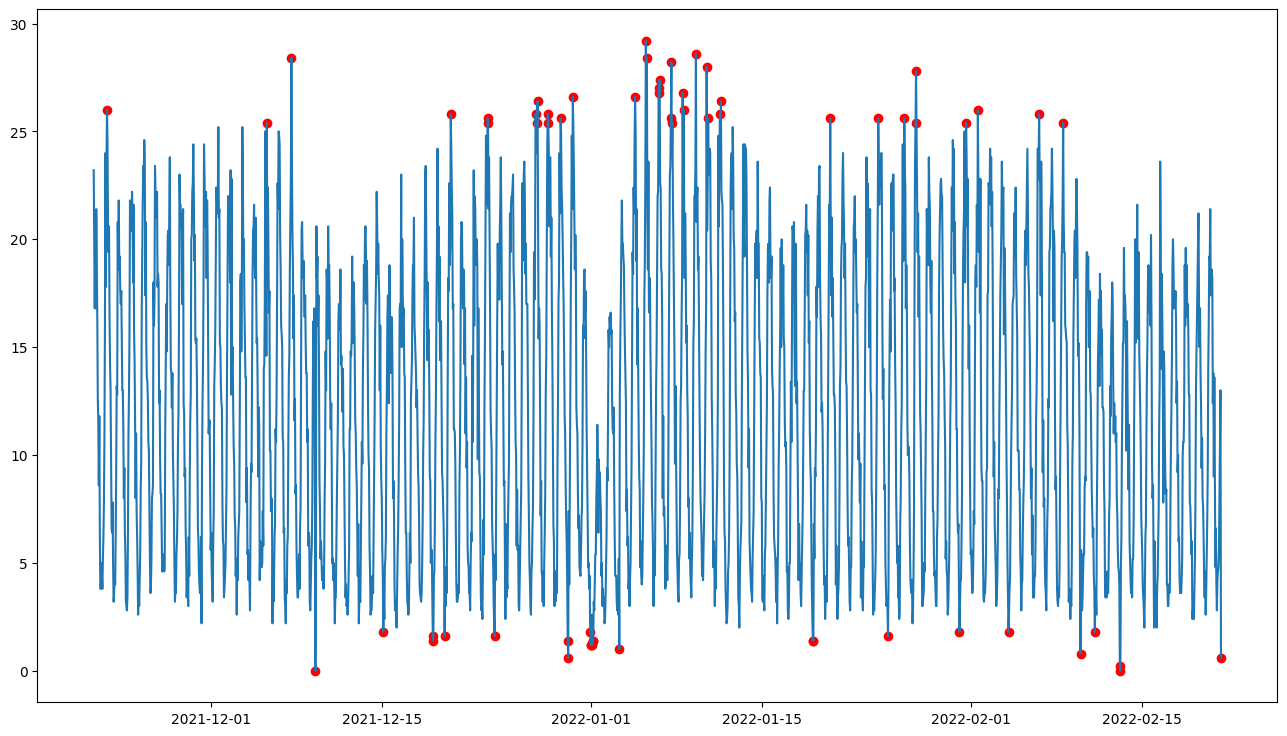

In [30]:
create_iso_forest_chart(data=top_5, coll='avg_top5', cont_factor=0.03)

#### Модель HBOS

In [36]:
detector = HBOS(contamination=0.03)

In [37]:
data = pd.DataFrame(top_5)
data.drop('avg_all', axis=1, inplace=True)

In [38]:
scaler = StandardScaler(with_mean=True)
np_scaled = scaler.fit_transform(data)
np_scaled = pd.DataFrame(np_scaled)
np_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2208 entries, 0 to 2207
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2208 non-null   float64
 1   1       2208 non-null   float64
 2   2       2208 non-null   float64
 3   3       2208 non-null   float64
 4   4       2208 non-null   float64
 5   5       2208 non-null   float64
 6   6       2208 non-null   float64
dtypes: float64(7)
memory usage: 120.9 KB


In [39]:
detector.fit(np_scaled)
pred = detector.predict(np_scaled)
data['anomaly'] = pred

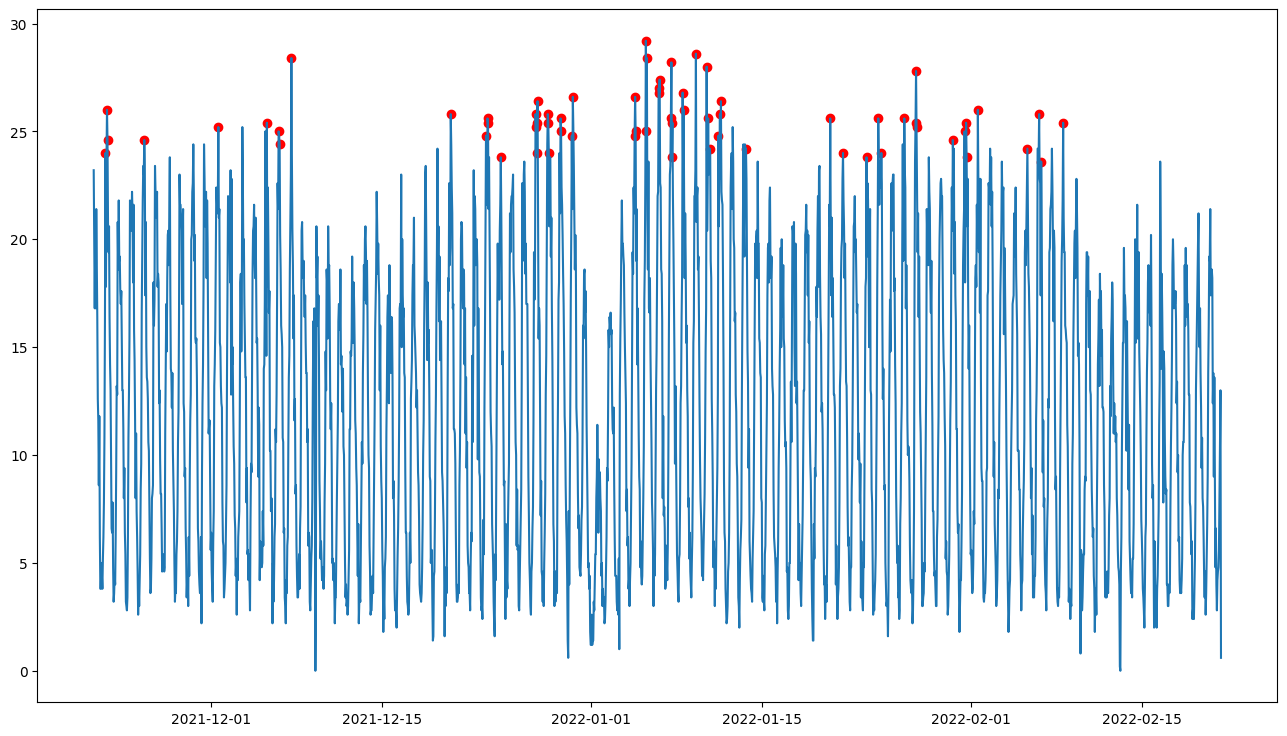

In [40]:
show_anomaly_chart(data, 'avg_top5', marker_digit=1)

### Выводы

Формулировка в ТЗ "в разрезе дня" была понята, как "выявить аномалии по часам в течении дня".

По результатам работы были использованы две модели, IsolationForest и HBOS.

Лучше всего показала себя модель HBOS - анализируя многомерный ряд, видно, что аномалии группируются в периоды новогодних праздников и перед ними, наблюдается большее число пиковых обращений.